# Implementation of infoGANs
Reference: https://arxiv.org/pdf/1606.03657.pdf

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [3]:
import numpy as np
import datetime
import scipy.misc

In [4]:
from tensorboardX import SummaryWriter

In [5]:
MODEL_NAME = 'infoGAN'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
def get_sample_image():
    """
        save sample 100 images
    """
    images = []
    # continuous code
    for cc_type in range(2):
        for num in range(10):
            fix_z = torch.randn(1, n_noise)
            z = to_cuda(fix_z)
            cc = -1
            for i in range(10):
                cc += 0.2
                c_discrete = to_cuda(to_onehot(num)) # (B,10)
                c_continuous = to_cuda(torch.zeros(1, n_c_continuous))
                c_continuous.data[:,cc_type].add_(cc)
                c = torch.cat((c_discrete.float(), c_continuous), 1)
                y_hat = G(z, c)
                line_img = torch.cat((line_img, y_hat.view(28, 28)), dim=1) if i > 0 else y_hat.view(28, 28)
            all_img = torch.cat((all_img, line_img), dim=0) if num > 0 else line_img
        img = all_img.cpu().data.numpy()
        images.append(img)
    # discrete code
    for num in range(10):
        c_discrete = to_cuda(to_onehot(num)) # (B,10)
        for i in range(10):
            z = to_cuda(torch.randn(1, n_noise))
            c_continuous = to_cuda(torch.zeros(1, n_c_continuous))
            c = torch.cat((c_discrete.float(), c_continuous), 1)
            y_hat = G(z, c)
            line_img = torch.cat((line_img, y_hat.view(28, 28)), dim=1) if i > 0 else y_hat.view(28, 28)
        all_img = torch.cat((all_img, line_img), dim=0) if num > 0 else line_img
    img = all_img.cpu().data.numpy()
    images.append(img)
    return images[0], images[1], images[2]

In [7]:
def to_cuda(x):
    return x.to(DEVICE)

In [8]:
def to_onehot(x, num_classes=10):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

In [9]:
def sample_noise(batch_size, n_noise, n_c_discrete, n_c_continuous, label=None, supervised=False):
    z = to_cuda(torch.randn(batch_size, n_noise))
    if supervised:
        c_discrete = to_cuda(to_onehot(label)) # (B,10)
    else:
        c_discrete = to_cuda(to_onehot(torch.LongTensor(batch_size, 1).random_(0, n_c_discrete))) # (B,10)
    c_continuous = to_cuda(torch.zeros(batch_size, n_c_continuous).uniform_(-1, 1)) # (B,2)
    c = torch.cat((c_discrete.float(), c_continuous), 1)
    return z, c

In [10]:
def log_gaussian(c, mu, var):
    """
        criterion for Q(condition classifier)
    """
    return -((c - mu)**2)/(2*var+1e-8) - 0.5*torch.log(2*np.pi*var+1e-8)

In [11]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel=1):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(# 28 -> 14
            nn.Conv2d(in_channel, 64, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
        )
        self.layer2 = nn.Sequential(# 14 -> 7
            nn.Conv2d(64, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
        )
        self.layer3 = nn.Sequential(#
            nn.Linear(128*7*7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
        )
        self.fc = nn.Sequential(
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        y_ = self.layer1(x)
        y_ = self.layer2(y_)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.layer3(y_)
        d = self.fc(y_) # Real / Fake        
        return d, y_ # return with top layer features for Q

In [12]:
class Qrator(nn.Module):
    """
        Regularization Network for increasing Mutual Information
    """
    def __init__(self):
        super(Qrator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1024, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 14),
        )
        
    def forward(self, x):
        # Seperate code
        c = self.fc(x)
        c_discrete = F.softmax(c[:, :10]) # Digit Label {0~9}
        c_mu = c[:, 10:12] # mu & var of Rotation & Thickness
        c_var = c[:, 12:14].exp() # mu & var of Rotation & Thickness
        return c_discrete, c_mu, c_var

In [13]:
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, input_size=62, code_size=12, num_classes=784):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_size+code_size, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(1024, 7*7*128),
            nn.BatchNorm1d(7*7*128),
            nn.ReLU(),
        )
        self.layer3 = nn.Sequential(# input: 7 by 7, output: 14 by 14
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer4 = nn.Sequential(# input: 14 by 14, output: 28 by 28
            nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )
        
    def forward(self, z, c):
        z = z.view(z.size(0), -1)
        c = c.view(c.size(0), -1)
        noise = torch.cat((z, c), 1)
#         print(noise.size())
        x_ = self.layer1(noise)
        x_ = self.layer2(x_)
        x_ = x_.view(x_.size(0), 128, 7, 7)
        x_ = self.layer3(x_)
        x_ = self.layer4(x_)
        return x_

In [14]:
D = to_cuda(Discriminator())
G = to_cuda(Generator())
Q = to_cuda(Qrator())
# D.load_state_dict('D_dc.pkl')
# G.load_state_dict('G_dc.pkl')

In [15]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                std=(0.5, 0.5, 0.5))]
)

In [16]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

In [17]:
batch_size = 128

In [18]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [19]:
bce_loss = nn.BCELoss()
ce_loss = nn.CrossEntropyLoss()

D_opt = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.99))
G_opt = torch.optim.Adam([{'params':G.parameters()}, {'params':Q.parameters()}], lr=1e-3, betas=(0.5, 0.99))

In [20]:
max_epoch = 200 # need more than 200 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 62
n_c_discrete, n_c_continuous = 10, 2

D_labels = to_cuda(torch.ones(batch_size)) # Discriminator Label to real
D_fakes = to_cuda(torch.zeros(batch_size)) # Discriminator Label to fake

In [21]:
writer = SummaryWriter()

In [22]:
for epoch in range(max_epoch+1):
    for idx, (images, labels) in enumerate(data_loader):
        step += 1
        labels = labels.view(batch_size, 1)
        # Training Discriminator
        x = to_cuda(images)
        x_outputs, _, = D(x)
        D_x_loss = bce_loss(x_outputs, D_labels)

        z, c = sample_noise(batch_size, n_noise, n_c_discrete, n_c_continuous, label=labels, supervised=True)
        z_outputs, _, = D(G(z, c))
        D_z_loss = bce_loss(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D_opt.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step > 500:
            # Training Generator
            z, c = sample_noise(batch_size, n_noise, n_c_discrete, n_c_continuous, label=labels, supervised=True)
            c_discrete_label = torch.max(c[:, :-2], 1)[1].view(-1, 1)
            
            z_outputs, features = D(G(z, c)) # (B,1), (B,10), (B,4)
            c_discrete_out, cc_mu, cc_var = Q(features)
            
            G_loss = bce_loss(z_outputs, D_labels)
            Q_loss_discrete = ce_loss(c_discrete_out, c_discrete_label.view(-1))
            Q_loss_continuous = -torch.mean(torch.sum(log_gaussian(c[:, -2:], cc_mu, cc_var), 1)) # N(x | mu,var) -> (B, 2) -> (,1)
            mutual_info_loss = Q_loss_discrete + Q_loss_continuous*0.1
            
            GnQ_loss = G_loss + mutual_info_loss

            G_opt.zero_grad()
            GnQ_loss.backward()
            G_opt.step()

        if step > 500 and step % 100 == 0:
            writer.add_scalar('loss/total', GnQ_loss, step)
            writer.add_scalar('loss/Q_discrete', Q_loss_discrete, step)
            writer.add_scalar('loss/Q_continuous', Q_loss_continuous, step)
            writer.add_scalar('loss/Q', mutual_info_loss, step)
            writer.add_histogram('output/mu', cc_mu)
            writer.add_histogram('output/var', cc_var)
        
        if step % 1000 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}, GnQ Loss: {}, Time: {}'\
                  .format(epoch, max_epoch, step, D_loss.data[0], G_loss.data[0], GnQ_loss.data[0], str(datetime.datetime.today())[:-7]))
            
        if epoch % 5 == 0:
            G.eval()
            img1, img2, img3 = get_sample_image()
            scipy.misc.imsave('sample/{}_epoch_{}_type1.jpg'.format(MODEL_NAME, epoch), img1)
            scipy.misc.imsave('sample/{}_epoch_{}_type2.jpg'.format(MODEL_NAME, epoch), img2)
            scipy.misc.imsave('sample/{}_epoch_{}_type3.jpg'.format(MODEL_NAME, epoch), img3)
            G.train()
writer.export_scalars_to_json("./all_summary.json")
writer.close()

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:52: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:53: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:54: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, 

Epoch: 2/200, Step: 1000, D Loss: 0.5892293453216553, G Loss: 1.9682375192642212, DnQ Loss: 4.170025825500488, Time: 2018-07-26 09:59:46
Epoch: 4/200, Step: 2000, D Loss: 0.708458423614502, G Loss: 1.4690847396850586, DnQ Loss: 3.3633322715759277, Time: 2018-07-26 10:00:46
Epoch: 6/200, Step: 3000, D Loss: 0.6872333884239197, G Loss: 1.845062255859375, DnQ Loss: 3.4502015113830566, Time: 2018-07-26 10:03:30
Epoch: 8/200, Step: 4000, D Loss: 0.830052375793457, G Loss: 1.6734484434127808, DnQ Loss: 3.3200511932373047, Time: 2018-07-26 10:04:31
Epoch: 10/200, Step: 5000, D Loss: 0.5874881744384766, G Loss: 1.6532411575317383, DnQ Loss: 3.2790403366088867, Time: 2018-07-26 10:06:42
Epoch: 12/200, Step: 6000, D Loss: 0.5144498944282532, G Loss: 1.9863836765289307, DnQ Loss: 3.6047587394714355, Time: 2018-07-26 10:08:16
Epoch: 14/200, Step: 7000, D Loss: 0.5166445374488831, G Loss: 2.0501909255981445, DnQ Loss: 3.666076183319092, Time: 2018-07-26 10:09:16
Epoch: 17/200, Step: 8000, D Loss: 0

KeyboardInterrupt: 

# Sample

/home/yangyangii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  This is separate from the ipykernel package so we can avoid doing imports until


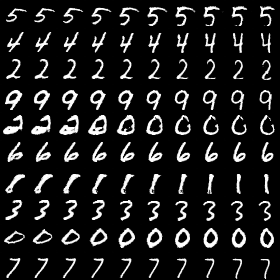

In [21]:
# generation to image
G.eval()
scipy.misc.toimage(get_sample_image()[0])

/home/yangyangii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  """Entry point for launching an IPython kernel.


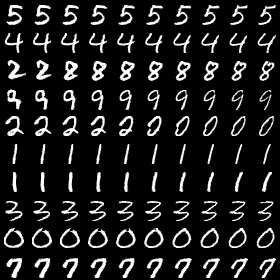

In [22]:
scipy.misc.toimage(get_sample_image()[1])

In [81]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [82]:
# Saving params.
# torch.save(D.state_dict(), 'D_c.pkl')
# torch.save(G.state_dict(), 'G_c.pkl')
save_checkpoint({'epoch': epoch + 1, 'state_dict':DnQ.state_dict(), 'optimizer' : DnQ_opt.state_dict()}, 'DnQ_info.pth.tar')
save_checkpoint({'epoch': epoch + 1, 'state_dict':G.state_dict(), 'optimizer' : G_opt.state_dict()}, 'G_info.pth.tar')